In [ ]:
!pip install datasets
!pip install transformers
!pip install timm
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 22.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.1 MB/s eta 0:00

In [ ]:
# load libraries
from datasets import load_dataset, load_from_disk
import torch
from torchvision.ops import box_convert, box_area
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
from transformers import AutoImageProcessor, AutoModelForObjectDetection, TrainingArguments, Trainer

import albumentations
import numpy as np
import copy


In [ ]:
# load dataset for the first time from huggingface
#raw_data = load_dataset("Kili/plastic_in_river")


In [ ]:
# save dataset to disk after having it loaded for the first time
#ds.save_to_disk("plastic-data")

In [ ]:
#!zip -r /content/plastic-data.zip /content/plastic-data

In [ ]:
## load dataset from disk, as it is faster than to always load it from huggingface
#raw_data = load_from_disk("/content/drive/MyDrive/Master/plastic-data/plastic-data")

In [ ]:
#raw_data['train'][0]

In [ ]:
image_id = 0
id = 0

def to_right_format(im):
  global image_id
  global id
  id_list = []

  w = im['image'].size[0]
  h = im['image'].size[1]
  #box = resize_bbox(im['litter'][0]['bbox'], w, h)

  bbox = im['litter']['bbox'].copy()
  for x in range(len(bbox)):
      bbox[x][0] = bbox[x][0] * w
      bbox[x][1] = bbox[x][1] * h
      bbox[x][2] = bbox[x][2] * w
      bbox[x][3] = bbox[x][3] * h
      id_list.append(id)
      id = id + 1
  try:
    area = box_area(box_convert(torch.tensor(bbox), 'cxcywh', 'xyxy')).tolist()
  except:
    area = []
      
  dic = {
      'image_id': image_id,
      'image': im['image'],
      'width': w,
      'height': h,
      'objects': {
        'id': id_list,
        'area': area,
        'bbox': bbox,
        'category': im['litter']['label']
      }
  }
  image_id = image_id + 1
  return dic


In [ ]:
#ds = raw_data.map(to_right_format)

In [ ]:
#ds['train'][0]

In [ ]:
#ds['train'][1]['objects']['bbox']

In [ ]:
# categories = ds['train'].features['litter'].feature['label']
# to_pil_image(
#       draw_bounding_boxes(
#           pil_to_tensor(ds['train'][1]['image']),
#           box_convert(torch.tensor(ds['train'][1]['objects']['bbox']), 'cxcywh', 'xyxy'),
#           colors='red',
#           labels=[categories.int2str(x) for x in ds['train'][1]['objects']['category']]
#       )
# )

In [ ]:
#ds.save_to_disk("/content/drive/MyDrive/Master/plastic-data/dataset")

In [ ]:
ds = load_from_disk("/content/drive/MyDrive/Master/plastic-data/dataset")

In [ ]:
ds['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1280x720 at 0x7F97300B8FD0>,
 'litter': {'label': [2, 2],
  'bbox': [[888.0577392578125,
    122.93060302734375,
    22.940988540649414,
    8.451943397521973],
   [713.58544921875,
    130.1751251220703,
    27.77066993713379,
    7.244522571563721]]},
 'image_id': 0,
 'width': 1280,
 'height': 720,
 'objects': {'area': [193.8965301513672, 201.18515014648438],
  'bbox': [[888.0577087402344,
    122.93060660362244,
    22.940988540649414,
    8.451943024992943],
   [713.5854339599609,
    130.17512440681458,
    27.77066946029663,
    7.244522497057915]],
  'category': [2, 2],
  'id': [0, 1]}}

In [ ]:
versuch = ds['train'].select(range(10))
versuch[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1280x720 at 0x7F972171C1C0>,
 'litter': {'label': [2, 2],
  'bbox': [[888.0577392578125,
    122.93060302734375,
    22.940988540649414,
    8.451943397521973],
   [713.58544921875,
    130.1751251220703,
    27.77066993713379,
    7.244522571563721]]},
 'image_id': 0,
 'width': 1280,
 'height': 720,
 'objects': {'area': [193.8965301513672, 201.18515014648438],
  'bbox': [[888.0577087402344,
    122.93060660362244,
    22.940988540649414,
    8.451943024992943],
   [713.5854339599609,
    130.17512440681458,
    27.77066946029663,
    7.244522497057915]],
  'category': [2, 2],
  'id': [0, 1]}}

In [ ]:
versuch = versuch.remove_columns("litter")
versuch

Dataset({
    features: ['image', 'image_id', 'width', 'height', 'objects'],
    num_rows: 10
})

In [ ]:
versuch[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1280x720 at 0x7F97300E19A0>,
 'image_id': 0,
 'width': 1280,
 'height': 720,
 'objects': {'area': [193.8965301513672, 201.18515014648438],
  'bbox': [[888.0577087402344,
    122.93060660362244,
    22.940988540649414,
    8.451943024992943],
   [713.5854339599609,
    130.17512440681458,
    27.77066946029663,
    7.244522497057915]],
  'category': [2, 2],
  'id': [0, 1]}}

In [ ]:
# all possible object categories
categories = ds['train'].features['litter'].feature['label']
categories
cat = ds['train'].features['litter'].feature['label'].names
id2label = {index: x for index, x in enumerate(cat, start=0)}
label2id = {v: k for k, v in id2label.items()}

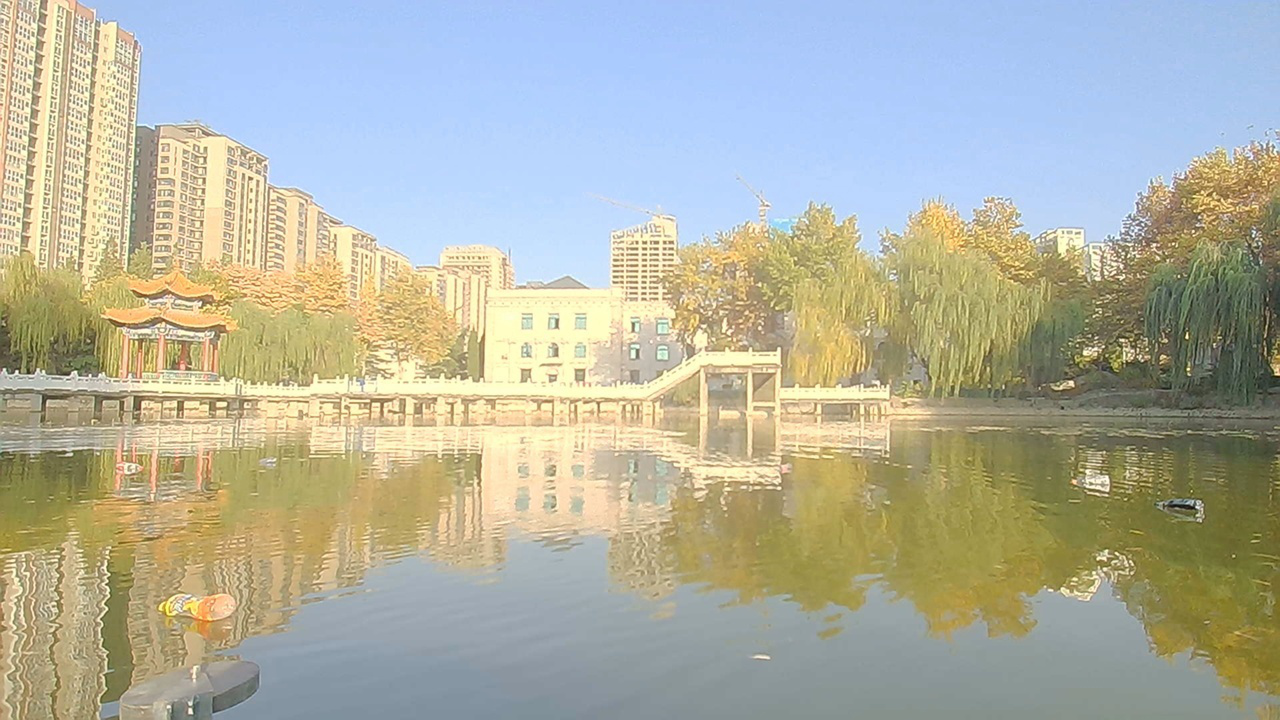

In [ ]:
# show image without bbox
ds['train'][2]['image']

In [ ]:
def draw_bb(example):
  return to_pil_image(
        draw_bounding_boxes(
            pil_to_tensor(example['image']),
            box_convert(torch.tensor(example['objects']['bbox']), 'cxcywh', 'xyxy'),
            colors='red',
            labels=[categories.int2str(x) for x in example['objects']['category']]
        )
  )

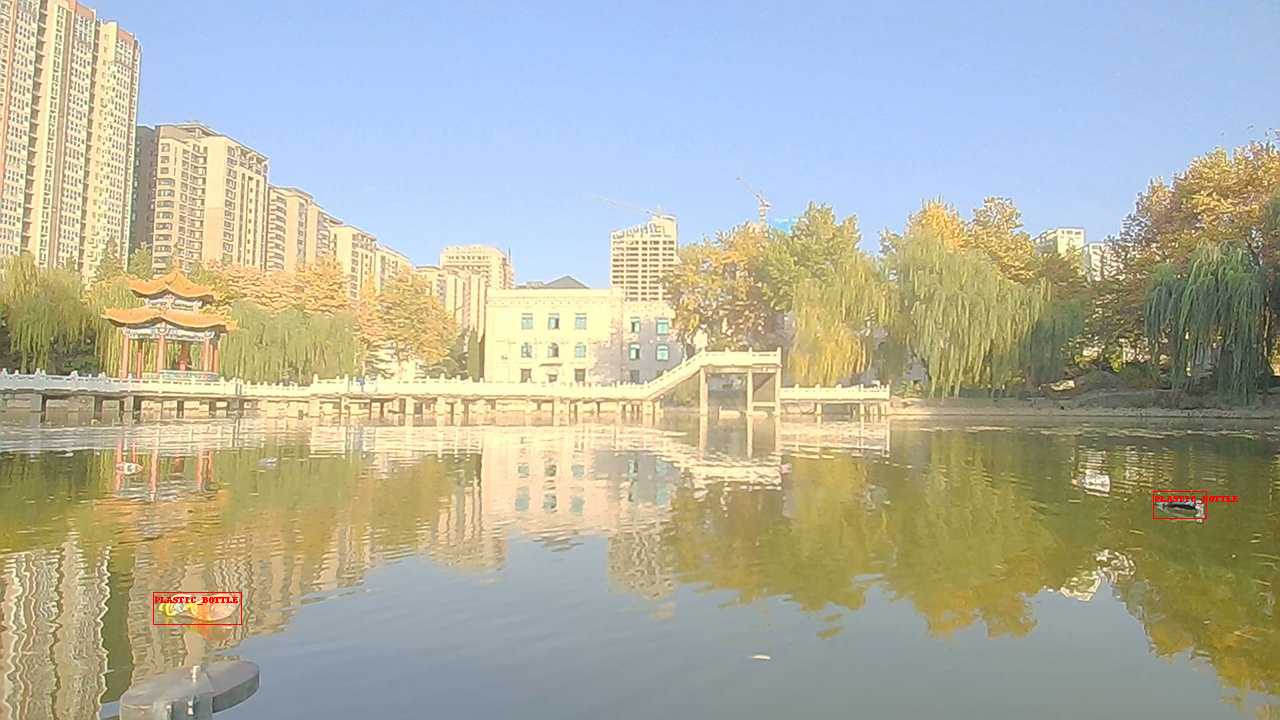

In [ ]:
draw_bb(ds['train'][2])

In [ ]:
checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [ ]:
img_size = 720
augmentation = albumentations.Compose(
    [
    albumentations.Resize(img_size, img_size),
     albumentations.RandomRotate90(),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightnessContrast(p=1.0),
    ], bbox_params=albumentations.BboxParams(format='coco',  label_fields=['category'])
)



transform_test = albumentations.Compose(
    [
        albumentations.Resize(img_size, img_size),

    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [ ]:
def aug(examples):
    images, bboxes, categories = [], [], []
    for image, objects in zip(examples['image'], examples['objects']):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        try:
          box = box_convert(torch.tensor(objects['bbox']), 'cxcywh', 'xywh').tolist()
        except:
          box = []
        out = augmentation(
            image=image,
            bboxes=box,
            category=objects['category']
        )
        images.append(torch.tensor(out['image']).flip(-1).permute(2, 0, 1))
        bboxes.append(out["bboxes"])
        categories.append(out['category'])
    return {'image': images, 'bbox': bboxes, 'category': categories}

In [ ]:
ds_aug = ds['train'].select(range(5))
ds_aug = ds_aug.with_transform(aug)

In [ ]:
def draw_bb2(example):
  return to_pil_image(
        draw_bounding_boxes(
            example['image'],
            box_convert(torch.tensor(example['bbox']), 'xywh', 'xyxy'),
            colors='red',
            labels=[categories.int2str(x) for x in example['category']]
        )
  )

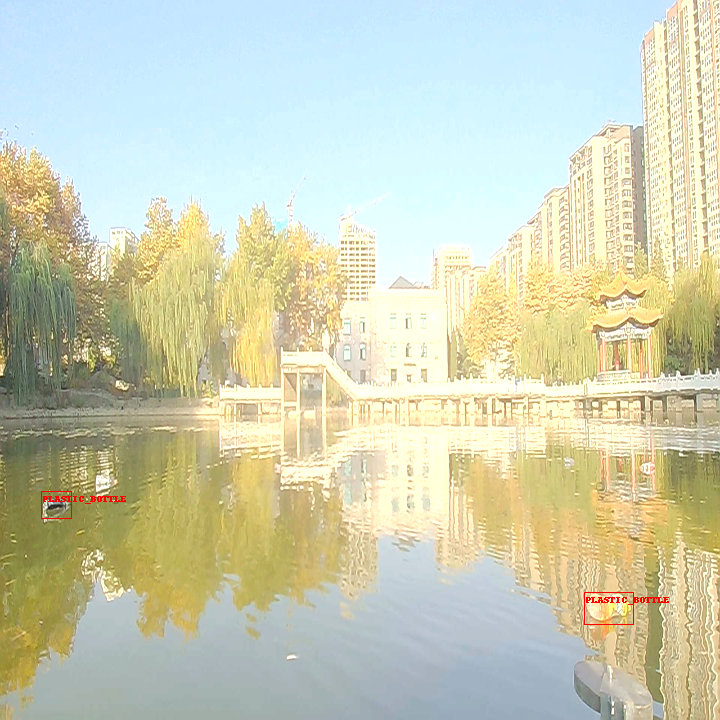

In [ ]:
draw_bb2(ds_aug[2])

In [ ]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [ ]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        try:
          box = box_convert(torch.tensor(objects['bbox']), 'cxcywh', 'xywh').tolist()
        except:
          box = []

        out = augmentation(
            image=image, 
            bboxes=box, 
            category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

def transform_aug_ann_val(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        try:
          box = box_convert(torch.tensor(objects['bbox']), 'cxcywh', 'xywh').tolist()
        except:
          box = []
        out = transform_test(image=image, bboxes=box, category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [ ]:
train = ds['train'].with_transform(transform_aug_ann)
val = ds['validation'].with_transform(transform_aug_ann_val)


In [ ]:
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    num_labels=len(cat),
    ignore_mismatched_sizes=True,
)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [ ]:
train2 = train.select(range(1000))

In [ ]:
training_args = TrainingArguments(
    output_dir="detr50_finetuned_plastic-in-rivers",
    per_device_train_batch_size=20,
    num_train_epochs=20,
    seed=42,
    save_strategy="steps",
    logging_steps=250,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="loss"
)

In [ ]:
# remove corrupt data from train dataset
# idx found out with below loop in comments for train and val dataset
remove_idx = [1012, 1560, 1734, 1845, 2447, 3057, 3060, 3359]
keep = [i for i in range(len(train)) if i not in remove_idx]
train = train.select(keep)

# remove corrput data from validation set
remove_idx_val= [149, 155, 353]
keep_val = [i for i in range(len(val)) if i not in remove_idx_val]
val = val.select(keep_val)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train,
    tokenizer=image_processor,
    eval_dataset=val,
)


In [ ]:
# check for corrupt data
# remove_idx= []
# for i in range(len(train)):
#   try:
#     train[i]
#   except:
#     print("corrupt: " + str(i))
#     remove_idx.append(i)
#     continue

# keep = [i for i in range(len(train)) if i not in remove_idx]
# train = train.select(keep)

In [ ]:
# check for corrupt data
# remove_idx_val= []
# for i in range(len(val)):
#   try:
#     val[i]
#   except:
#     print("corrupt: " + str(i))
#     remove_idx_val.append(i)
#     continue

# keep_val = [i for i in range(len(val)) if i not in remove_idx_val]
# val = val.select(keep_val)

In [ ]:
trainer.train()

TrainOutput(global_step=3400, training_loss=1.7951904880299288, metrics={'train_runtime': 8923.5496, 'train_samples_per_second': 7.618, 'train_steps_per_second': 0.381, 'total_flos': 3.248773127677439e+19, 'train_loss': 1.7951904880299288, 'epoch': 20.0})

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Master/finetuned-model-v6-imgsize720-20epochs")

In [ ]:
model2 = AutoModelForObjectDetection.from_pretrained("/content/drive/MyDrive/Master/finetuned-model-v5-imgsize480")

In [ ]:
model3 = AutoModelForObjectDetection.from_pretrained("/content/drive/MyDrive/Master/finetuned-model-v6-imgsize720-20epochs")

In [ ]:
model = AutoModelForObjectDetection.from_pretrained("/content/drive/MyDrive/Master/finetuned-model-v4")

In [ ]:
import json


# format annotations the same as for training, no need for data augmentation
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations


# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_cppe5_annotation_file_images(cppe5):
    output_json = {}
    path_output_cppe5 = f"{os.getcwd()}/cppe5/"

    if not os.path.exists(path_output_cppe5):
        os.makedirs(path_output_cppe5)

    path_anno = os.path.join(path_output_cppe5, "cppe5_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in cppe5:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(cppe5["image"], cppe5["image_id"]):
        path_img = os.path.join(path_output_cppe5, f"{img_id}.png")
        im.save(path_img)

    return path_output_cppe5, path_anno

In [ ]:
import torchvision
import os


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file):
        super().__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


#im_processor = AutoImageProcessor.from_pretrained("MariaK/detr-resnet-50_finetuned_cppe5")

path_output_cppe5, path_anno = save_cppe5_annotation_file_images(ds['test'].select(range(100)))
test_ds_coco_format = CocoDetection(path_output_cppe5, image_processor, path_anno)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
import evaluate
from tqdm import tqdm

#model = AutoModelForObjectDetection.from_pretrained("MariaK/detr-resnet-50_finetuned_cppe5")
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"].cuda()
        pixel_mask = batch["pixel_mask"].cuda()

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = image_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO api

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [ ]:
from transformers import pipeline

image = ds['train'][1]['image']

obj_detector = pipeline("object-detection", model=model, image_processor=image_processor)
obj_detector(image)

[]

In [ ]:
image = ds['test'][3]['image']

with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model3(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model2.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected PLASTIC_BOTTLE with confidence 0.692 at location [636.76, 443.28, 651.51, 457.94]
Detected PLASTIC_BOTTLE with confidence 0.694 at location [341.92, 450.57, 361.07, 461.98]
Detected PLASTIC_BOTTLE with confidence 0.556 at location [635.13, 434.47, 648.91, 442.5]
Detected PLASTIC_BOTTLE with confidence 0.671 at location [341.17, 451.0, 359.4, 461.54]
Detected PLASTIC_BOTTLE with confidence 0.685 at location [635.05, 437.74, 649.91, 448.56]
Detected PLASTIC_BOTTLE with confidence 0.525 at location [340.1, 451.81, 357.45, 461.73]
Detected PLASTIC_BOTTLE with confidence 0.572 at location [635.66, 441.91, 649.1, 453.7]


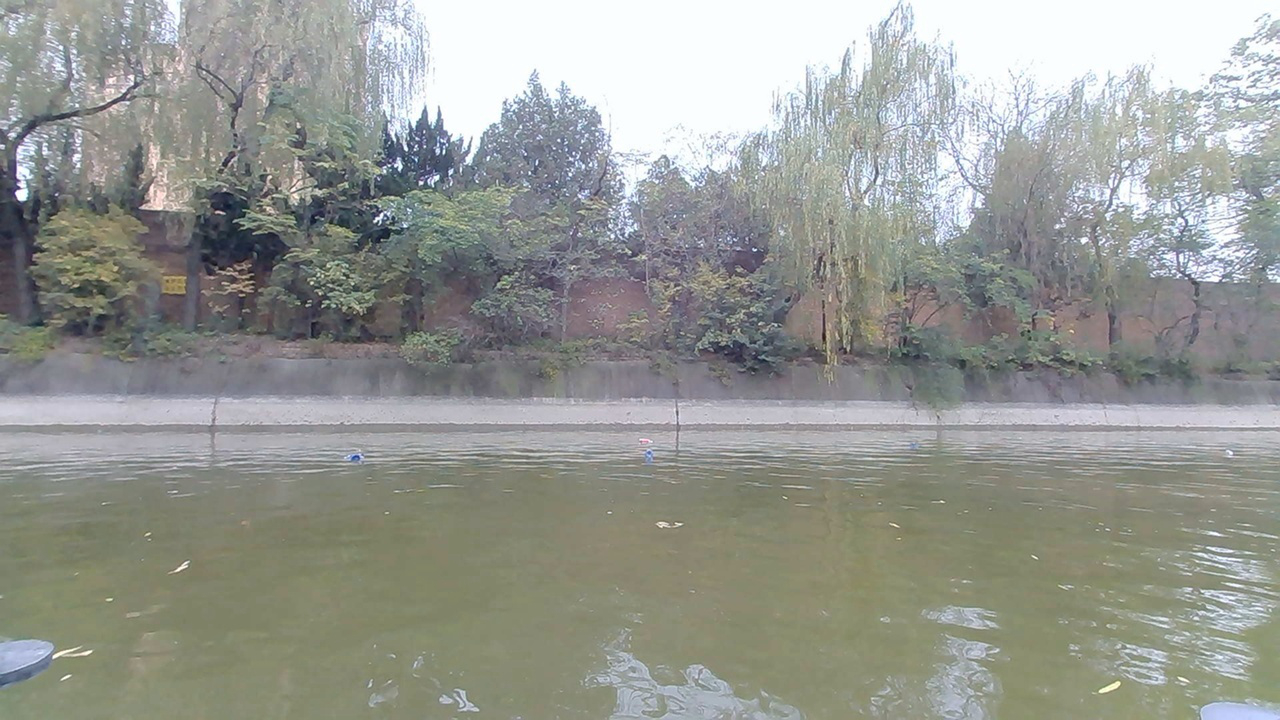

In [ ]:
ds['test'][3]['image']

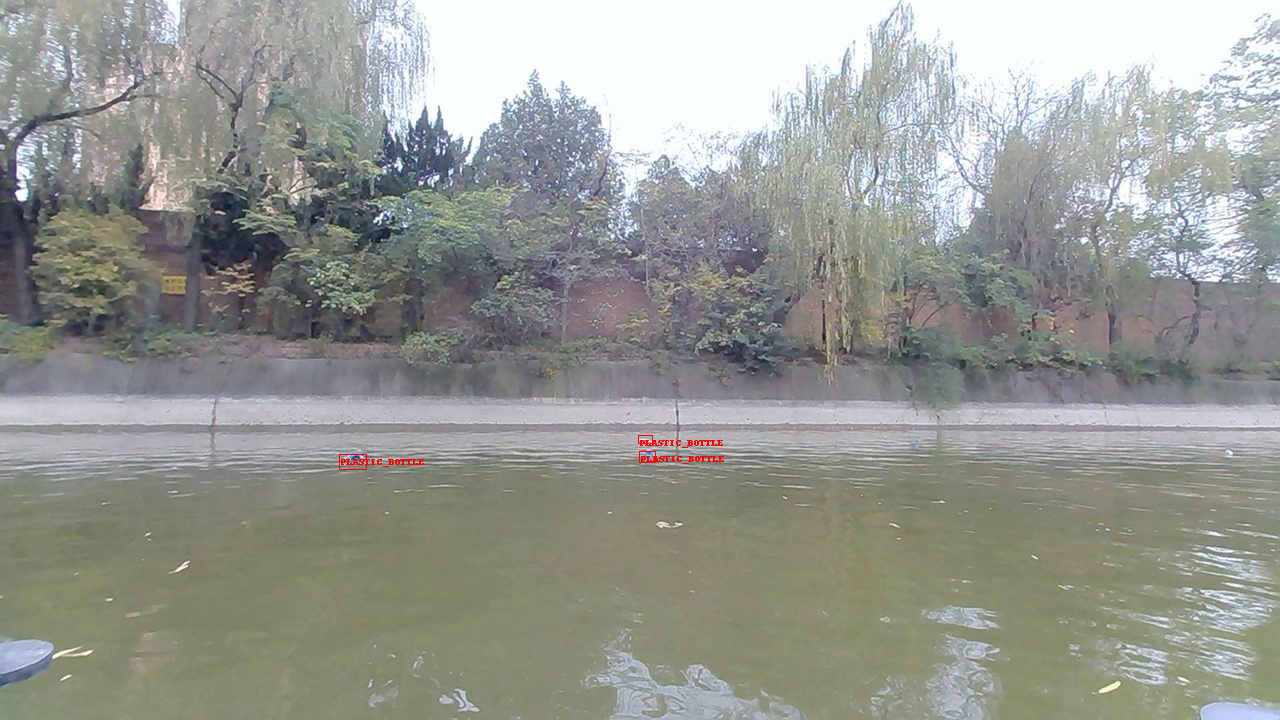

In [ ]:
draw_bb(ds['test'][3])

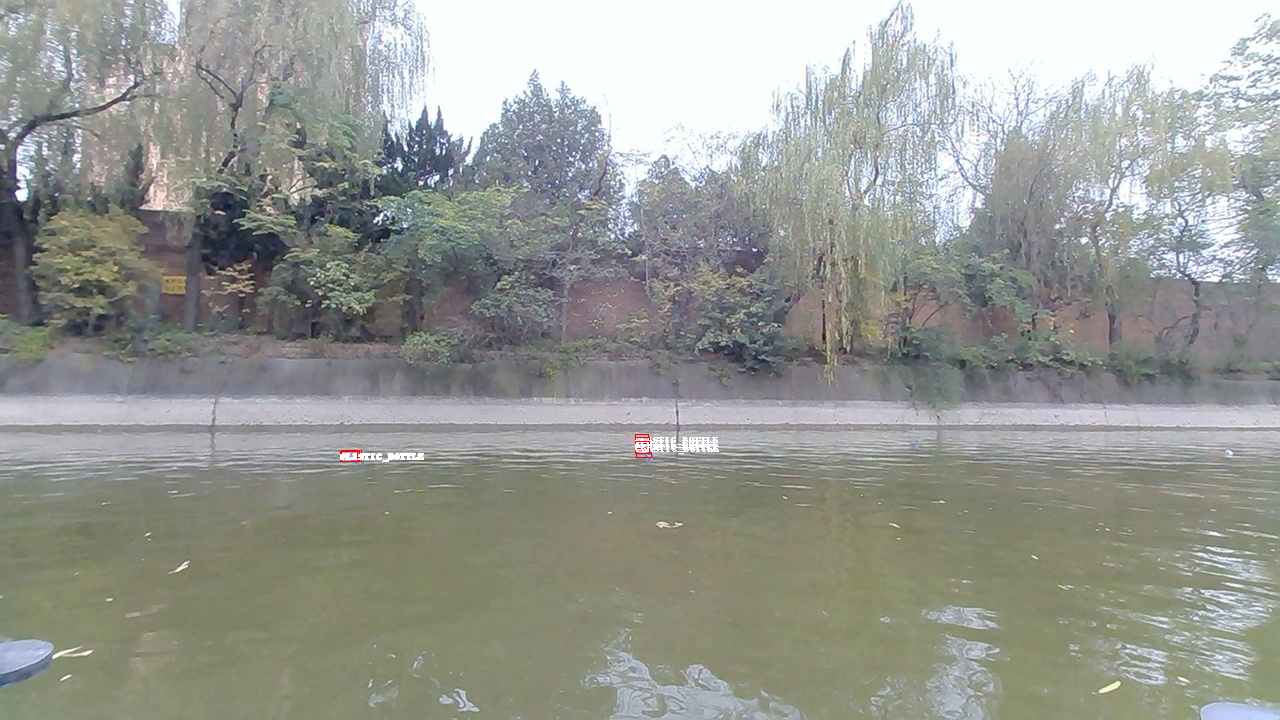

In [ ]:
from PIL import Image, ImageDraw
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image

In [ ]:
def transforms(examples):
    images, bboxes, categories = [], [], []
    for image, objects in zip(examples['image'], examples['litter']):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        #box = box_convert(torch.tensor(resize_bbox(objects['bbox'], width, height)), 'cxcywh', 'xywh')
        box = objects['bbox']
        out = augmentation(
            image=image,
            bboxes=box,
            category=objects['label']
        )
        images.append(torch.tensor(out['image']).flip(-1).permute(2, 0, 1))
        bboxes.append(torch.multiply(torch.tensor(out['bboxes']), img_size))
        categories.append(out['category'])

    return {'image': images, 'bbox': bboxes, 'category': categories}

In [ ]:
#train.set_transform(transforms)
augmented = raw_data['train'].with_transform(transforms).select(range(10))
#with_transform returns new dataset object, set_transforms transforms when an object of the dataset is called

In [ ]:
def pil_image(example):
  return to_pil_image(
      draw_bounding_boxes(
          example['image'],
          box_convert(example['bbox'], 'cxcywh', 'xyxy'),
          colors='red',
          labels=[categories.int2str(x) for x in example['category']]
      )
  )

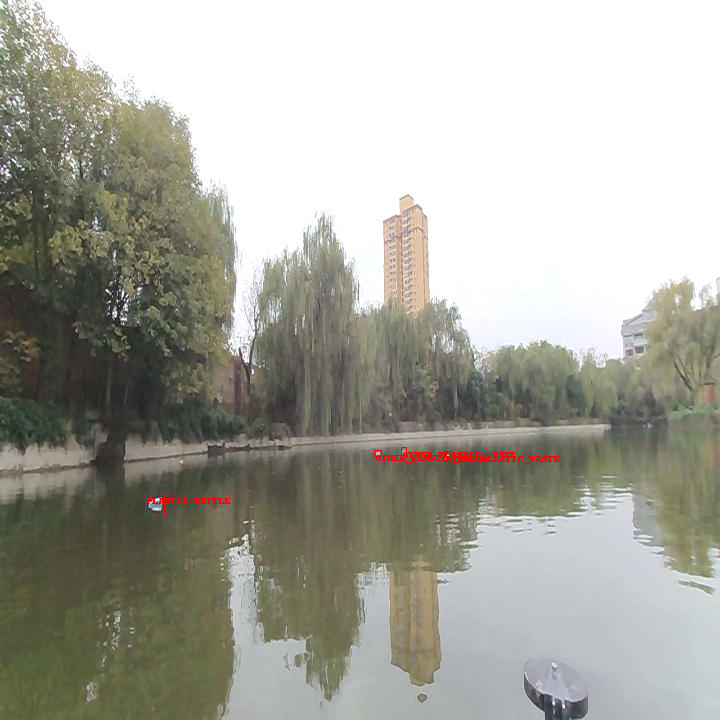

In [ ]:
pil_image(augmented[1])

In [ ]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [ ]:
checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [ ]:
# transforming a batch
id = 0
def transform_aug_ann(examples):
    global id
    image_ids, images, bboxes, area, categories = [], [], [], [], []

    for image, objects in zip(examples['image'], examples['litter']):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        box = objects['bbox']
        #try:
        #  box = box_convert(torch.tensor(resize_bbox(objects['bbox'], width, height)), 'cxcywh', 'xywh')
        #except:
        #  box = []
        out = transform(
            image=image,
            bboxes=box,
            category=objects['label']
        )
        image_ids.append(id)
        id = id + 1
        images.append(out['image'])
        try:
          area.append(box_area(box_convert(torch.multiply(torch.tensor(out['bboxes']), img_size), 'cxcywh', 'xyxy')).tolist()) # box_area expects format xyxy
          #area.append(box_area(box_convert(torch.tensor(out['bboxes']), 'xywh', 'xyxy')))
        except:
          area.append([])
        #bboxes.append(out['bboxes'])
        try:
          bboxes.append(box_convert(torch.multiply(torch.tensor(out['bboxes']), img_size), 'cxcywh', 'xywh').tolist()) # model expects COCO format xywh
        except:
          bboxes.append([])
        categories.append(out['category'])


    targets = [
            {"image_id": id_, "annotations": formatted_anns(id_, cat_,ar_, box_)}
            for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
        ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")


def transform_ann_val(examples):
    global id
    image_ids, images, bboxes, area, categories = [], [], [], [], []

    for image, objects in zip(examples['image'], examples['litter']):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        box = objects['bbox']
        out = transform_test(
            image=image,
            bboxes=box,
            category=objects['label']
        )
        image_ids.append(id)
        id = id + 1
        images.append(out['image'])

        try:
          area.append(box_area(box_convert(torch.multiply(torch.tensor(out['bboxes']), img_size), 'cxcywh', 'xyxy')).tolist()) # box_area expects format xyxy
          #area.append(box_area(box_convert(torch.tensor(out['bboxes']), 'xywh', 'xyxy')))
        except:
          area.append([])
        #bboxes.append(out['bboxes'])
        try:
          bboxes.append(box_convert(torch.multiply(torch.tensor(out['bboxes']), img_size), 'cxcywh', 'xywh').tolist()) # model expects COCO format xywh
        except:
          bboxes.append([])
          
        categories.append(out['category'])


    targets = [
            {"image_id": id_, "annotations": formatted_anns(id_, cat_,ar_, box_)}
            for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
        ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [ ]:
tf = transform_aug_ann(ds['train'].select(range(10)))

In [ ]:
resize_and_plot_image(ds['train'][48])

In [ ]:
train = ds['train'].with_transform(transform_aug_ann) #set_transform is applied on the fly, when an object of the dataset is called; with_transform creates a new dataset

In [ ]:
train=train.select(range(1000))
val=ds['validation'].with_transform(transform_ann_val)#.select(range(5))

In [ ]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = [dict(label) for label in labels]
    return batch

In [ ]:
# initialize model
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    num_labels=len(cat),
    ignore_mismatched_sizes=True,
)

In [ ]:
training_args = TrainingArguments(
    output_dir="detr50_finetuned_plastic-in-rivers",
    per_device_train_batch_size=20,
    num_train_epochs=20,
    seed=42,
    save_strategy="steps",
    logging_steps=100,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="loss"
)

In [ ]:
#remove_idx = [84, 231, 234, 279, 360, 383, 429, 489, 547, 694, 698, 734, 770, 806, 829, 841, 894, 898, 934, 994]
#keep = [i for i in range(len(train)) if i not in remove_idx]
#train = train.select(keep)

In [ ]:
# check for corrupt data
remove_idx_val= []
for i in range(len(val)):
  try:
    val[i]
  except:
    print("corrupt: " + str(i))
    remove_idx_val.append(i)
    continue

keep_val = [i for i in range(len(val)) if i not in remove_idx_val]
val = val.select(keep_val)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train,
    tokenizer=image_processor,
    eval_dataset=val,
    #compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Master/finetuned-model-v3")

In [ ]:
model = AutoModelForObjectDetection.from_pretrained("/content/drive/MyDrive/Master/finetuned-model-v3")

In [ ]:
model = model.cuda()

In [ ]:
pred_step = trainer.evaluate()

In [ ]:
pred_step

In [ ]:
test=ds['test'].with_transform(transform_ann_val).select(range(10))

In [ ]:
test

In [ ]:
predictions_test = trainer.predict(test)

In [ ]:
print(predictions_test.label_ids)

In [ ]:
import numpy as np

preds = np.argmax(predictions_test.predictions, axis=-1)

In [ ]:
remove_idx= []
for i in range(len(train)):
  try:
    train[i]
  except:
    print("geht nicht: " + str(i))
    remove_idx.append(i)
    continue
  

In [ ]:
# format annotations the same as for training, no need for data augmentation
def val_formatted_anns(image, id, objects):
    annotations = []
    try:
      box = box_convert(torch.multiply(torch.tensor(objects['bbox']), img_size), 'cxcywh', 'xyxy').tolist()
      area = box_area(torch.tensor(box)).tolist()
    except:
      box = []
      area= []
    

    for i in range(0, len(objects["label"])):
        new_ann = {
            "id": id,
            "category_id": objects["label"][i],
            "iscrowd": 0,
            "image_id": id,
            "area": area[i].tolist(),
            "bbox": box[i].tolist(),
        }
        annotations.append(new_ann)

    return annotations

In [ ]:
import json
import os

# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_annotation_file_images(plastic):
    id = 0
    output_json = {}
    path_output = f"/plastic/"

    if not os.path.exists(path_output):
        os.makedirs(path_output)

    path_anno = os.path.join(path_output, "plastic_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in plastic:
        ann = val_formatted_anns(example["image"], id, example["litter"])
        output_json["images"].append(
            {
                "id": id,
                "width": example["image"].size[0],
                "height": example["image"].size[1],
                "file_name": f"{id}.png",
            }
        )
        output_json["annotations"].extend(ann)
        id = id + 1
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    id = 0
    for im in plastic["image"]:
        
        path_img = os.path.join(path_output, f"{id}.png")
        im.save(path_img)
        id = id + 1

    return path_output, path_anno

In [ ]:
test2 = ds['test']

In [ ]:
import torchvision


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file):
        super().__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}

In [ ]:
path_output, path_anno = save_annotation_file_images(test2)
test_ds_coco_format = CocoDetection(path_output, image_processor, path_anno)

In [ ]:
import evaluate
from tqdm import tqdm

module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"].cuda()
        pixel_mask = batch["pixel_mask"].cuda()

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]    # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = image_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO api

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

In [ ]:
resize_and_plot_image()

In [ ]:
l_model = AutoModelForObjectDetection.from_pretrained("/content/drive/MyDrive/Master/finetuned-model-v2")

In [ ]:
#from transformers import pipeline

obj_detector = pipeline("object-detection", model=l_model, image_processor=image_processor)
obj_detector(ds['train'][3]['image'])

In [ ]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image